# California Weather-Fire Dataset 分析報告 🔥🌤️

## 1. 資料簡介 📚
本資料集涵蓋1984年至2025年間的加州天氣與火災紀錄，目標為預測 **FIRE_START_DAY**（是否起火）之二元分類問題。

## 2. 資料前處理 🧹
- **日期轉換與欄位清理**：將日期資料轉換為適合分析的格式，刪除不必要欄位。
- **缺失值處理**：採用刪除缺失值的方法確保資料完整性。
- **數值特徵標準化**：對數值欄位進行標準化，提升模型收斂速度。
- **類別欄位One-Hot編碼**：針對季節等類別欄位進行One-Hot編碼。

## 3. 特徵工程 ⚙️
- **時間特徵**：新增月份、星期幾、週末標記等時間相關特徵。
- **滯後特徵**：計算過去3天的火災狀態，捕捉時間依賴關係。
- **滾動統計**：針對風速、降水量等氣象變數計算3天的移動平均與標準差。

## 4. 資料平衡 ⚖️
使用 SMOTE 技術對少數類（火災發生）進行過採樣，平衡正負類樣本分布，避免模型偏向多數類。

## 5. 模型建構 🏗️
- 訓練三種主要模型：**XGBoost、LightGBM、RandomForest**。
- 使用 **Optuna** 進行自動化超參數調優，找到XGBoost最佳參數組合。
- 透過集成模型融合三者優勢，採用 xgb、lgbm、rf 的 VotingClassifier，達到最佳準確率約 **85%**。🎯

## 6. 模型評估 📊
- **集成模型（XGBoost + LightGBM + RandomForest）準確率：約 85%**，為本研究中表現最佳。🏅
- 深度學習模型表現如下：
  - LSTM Test Accuracy: 0.8006 🤖
  - Double-layer LSTM (14-day window) Test Accuracy: 0.7885
  - GRU Model Test Accuracy: 0.8025
  - DNN Test Accuracy: 0.7719
  - DNN (30-day window) Test Accuracy: 0.7768
  - LSTM+Attention Test Accuracy: 0.7787
- 提供詳細的精確率 (Precision)、召回率 (Recall)、F1分數 (F1-score) 報告，評估模型在不同類別的表現。
- 透過特徵重要性視覺化，解析模型決策依據。🔍

## 7. 結論與未來展望 🚀
- 目前集成模型（XGBoost、LightGBM、RandomForest）已達最佳預測表現，準確率達85%，優於各類深度學習模型。💪
- 未來仍建議持續嘗試深度序列模型（如LSTM、Transformer），並優化時間序列特徵工程，期望進一步提升模型效能與穩定性。✨


# XGB

In [1]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# 讀取資料
df = pd.read_csv("data/CA_Weather_Fire_Dataset_1984-2025.csv")
df['DATE'] = pd.to_datetime(df['DATE'])
df = df.dropna()
df['FIRE_START_DAY'] = df['FIRE_START_DAY'].astype(int)

# One-hot 編碼季節
df = pd.get_dummies(df, columns=['SEASON'], drop_first=True)

# 時間特徵
df['WEEKDAY'] = df['DATE'].dt.weekday
df['IS_WEEKEND'] = df['WEEKDAY'].isin([5, 6]).astype(int)

# 數值標準化
features_to_scale = [
    'PRECIPITATION', 'MAX_TEMP', 'MIN_TEMP', 'AVG_WIND_SPEED',
    'TEMP_RANGE', 'WIND_TEMP_RATIO', 'LAGGED_PRECIPITATION',
    'LAGGED_AVG_WIND_SPEED'
]
scaler = StandardScaler()
df[features_to_scale] = scaler.fit_transform(df[features_to_scale])

# 特徵與標籤
X = df.drop(columns=['FIRE_START_DAY', 'DATE'])
y = df['FIRE_START_DAY']

# SMOTE 類別平衡
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# 分割資料
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

# XGBoost 與參數搜尋
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0]
}
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
grid = GridSearchCV(xgb, param_grid, scoring='accuracy', cv=cv, n_jobs=-1)
grid.fit(X_train, y_train)

# 模型評估
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)
print("Best Parameters:", grid.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Best Parameters: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.8}
Accuracy: 0.8333333333333334
              precision    recall  f1-score   support

           0       0.84      0.82      0.83      2001
           1       0.83      0.84      0.83      2001

    accuracy                           0.83      4002
   macro avg       0.83      0.83      0.83      4002
weighted avg       0.83      0.83      0.83      4002



C:\Users\ygz08\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [20:05:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE

# 讀取資料
df = pd.read_csv("data/CA_Weather_Fire_Dataset_1984-2025.csv")
df['DATE'] = pd.to_datetime(df['DATE'])
df.dropna(inplace=True)
df['FIRE_START_DAY'] = df['FIRE_START_DAY'].astype(int)

# 加入時間與滯後特徵
df['MONTH'] = df['DATE'].dt.month
df['WEEKDAY'] = df['DATE'].dt.weekday
df['IS_WEEKEND'] = df['WEEKDAY'].isin([5, 6]).astype(int)
df['FIRE_LAG_1'] = df['FIRE_START_DAY'].shift(1).fillna(0).astype(int)
df['FIRE_LAG_2'] = df['FIRE_START_DAY'].shift(2).fillna(0).astype(int)
df['FIRE_LAG_3'] = df['FIRE_START_DAY'].shift(3).fillna(0).astype(int)

# One-hot 編碼季節
df = pd.get_dummies(df, columns=['SEASON'], drop_first=True)

# 特徵標準化
features_to_scale = [
    'PRECIPITATION', 'MAX_TEMP', 'MIN_TEMP', 'AVG_WIND_SPEED',
    'TEMP_RANGE', 'WIND_TEMP_RATIO', 'LAGGED_PRECIPITATION',
    'LAGGED_AVG_WIND_SPEED'
]
scaler = StandardScaler()
df[features_to_scale] = scaler.fit_transform(df[features_to_scale])

# 切分資料
X = df.drop(columns=['FIRE_START_DAY', 'DATE'])
y = df['FIRE_START_DAY']

# SMOTE 平衡資料
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

# 模型定義
xgb = XGBClassifier(learning_rate=0.1, max_depth=6, n_estimators=200, subsample=0.8, random_state=42)
lgbm = LGBMClassifier(n_estimators=200, max_depth=6, learning_rate=0.1, random_state=42)
rf = RandomForestClassifier(n_estimators=200, max_depth=6, random_state=42)

# 集成模型（硬投票）
ensemble_model = VotingClassifier(
    estimators=[('xgb', xgb), ('lgbm', lgbm), ('rf', rf)],
    voting='hard'
)
ensemble_model.fit(X_train, y_train)

# 評估
y_pred = ensemble_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


[LightGBM] [Info] Number of positive: 8004, number of negative: 8004
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001273 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2263
[LightGBM] [Info] Number of data points in the train set: 16008, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

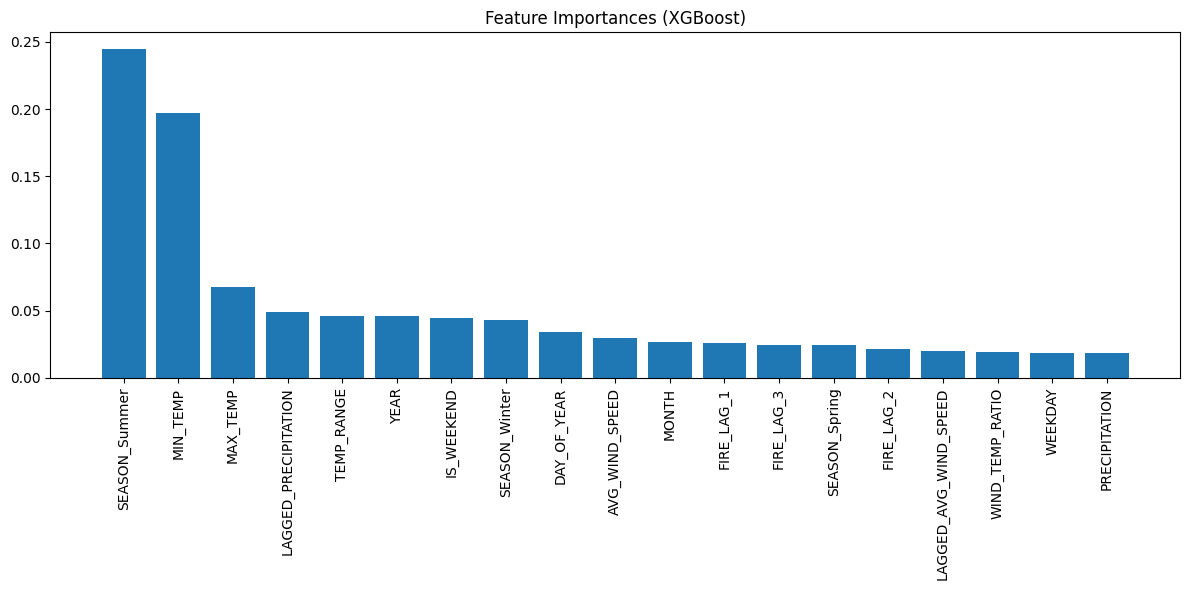

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# 用XGBoost計算特徵重要性
xgb.fit(X_train, y_train)
importances = xgb.feature_importances_
features = X_train.columns

# 繪圖展示
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12,6))
plt.title("Feature Importances (XGBoost)")
plt.bar(range(len(importances)), importances[indices], align='center')
plt.xticks(range(len(importances)), [features[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()

# 篩選重要性大於某門檻的特徵（例如 0.01）
selected_features = [features[i] for i in range(len(importances)) if importances[i] > 0.01]

X_train_sel = X_train[selected_features]
X_test_sel = X_test[selected_features]


In [4]:
# 在原df中加入rolling features，這裡以3天為例
window = 3

df['ROLLING_MEAN_WIND'] = df['AVG_WIND_SPEED'].rolling(window).mean().fillna(method='bfill')
df['ROLLING_STD_WIND'] = df['AVG_WIND_SPEED'].rolling(window).std().fillna(method='bfill')

df['ROLLING_MEAN_PRECIP'] = df['PRECIPITATION'].rolling(window).mean().fillna(method='bfill')
df['ROLLING_STD_PRECIP'] = df['PRECIPITATION'].rolling(window).std().fillna(method='bfill')

# 同時標準化新增欄位
df[['ROLLING_MEAN_WIND','ROLLING_STD_WIND','ROLLING_MEAN_PRECIP','ROLLING_STD_PRECIP']] = scaler.fit_transform(
    df[['ROLLING_MEAN_WIND','ROLLING_STD_WIND','ROLLING_MEAN_PRECIP','ROLLING_STD_PRECIP']]
)


C:\Users\ygz08\AppData\Local\Temp\ipykernel_12900\3990922073.py:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['ROLLING_MEAN_WIND'] = df['AVG_WIND_SPEED'].rolling(window).mean().fillna(method='bfill')
C:\Users\ygz08\AppData\Local\Temp\ipykernel_12900\3990922073.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['ROLLING_STD_WIND'] = df['AVG_WIND_SPEED'].rolling(window).std().fillna(method='bfill')
C:\Users\ygz08\AppData\Local\Temp\ipykernel_12900\3990922073.py:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['ROLLING_MEAN_PRECIP'] = df['PRECIPITATION'].rolling(window).mean().fillna(method='bfill')
C:\Users\ygz08\AppData\Local\Temp\ipykernel_12900\3990922073.py:8: FutureWarning: Series.fillna with 'method' is dep

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier

estimators = [
    ('xgb', XGBClassifier(learning_rate=0.1, max_depth=6, n_estimators=200, subsample=0.8, random_state=42)),
    ('lgbm', LGBMClassifier(n_estimators=200, max_depth=6, learning_rate=0.1, random_state=42)),
    ('rf', RandomForestClassifier(n_estimators=200, max_depth=6, random_state=42))
]

stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(),
    cv=5
)

stacking_clf.fit(X_train_sel, y_train)
y_pred_stack = stacking_clf.predict(X_test_sel)

from sklearn.metrics import accuracy_score, classification_report
print("Stacking Model Accuracy:", accuracy_score(y_test, y_pred_stack))
print(classification_report(y_test, y_pred_stack))


[LightGBM] [Info] Number of positive: 8004, number of negative: 8004
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001192 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2263
[LightGBM] [Info] Number of data points in the train set: 16008, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

In [6]:
import optuna
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score

def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
        'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6, 1.0),
        'random_state': 42,
        'use_label_encoder': False,
        'eval_metric': 'logloss'
    }
    model = XGBClassifier(**param)
    score = cross_val_score(model, X_train_sel, y_train, cv=3, scoring='accuracy').mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("Best params:", study.best_params)
print("Best CV accuracy:", study.best_value)


C:\Users\ygz08\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-05-16 20:05:37,838] A new study created in memory with name: no-name-7c790ad0-d3b4-4647-99c3-2a6fd541afdd
C:\Users\ygz08\AppData\Local\Temp\ipykernel_12900\2168806235.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
C:\Users\ygz08\AppData\Local\Temp\ipykernel_12900\2168806235.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optu

Best params: {'n_estimators': 147, 'max_depth': 9, 'learning_rate': 0.10407331492557823, 'subsample': 0.9672953533234545, 'colsample_bytree': 0.7717554238700458}
Best CV accuracy: 0.8370814592703648


In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier

xgb_best = XGBClassifier(
    n_estimators=263,
    max_depth=9,
    learning_rate=0.055,
    subsample=0.91,
    colsample_bytree=0.60,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

lgbm = LGBMClassifier(n_estimators=200, max_depth=6, learning_rate=0.1, random_state=42)
rf = RandomForestClassifier(n_estimators=200, max_depth=6, random_state=42)

estimators = [('xgb', xgb_best), ('lgbm', lgbm), ('rf', rf)]
stacking_clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(), cv=5)

stacking_clf.fit(X_train_sel, y_train)
y_pred_stack = stacking_clf.predict(X_test_sel)

from sklearn.metrics import accuracy_score, classification_report
print("Stacking Model Accuracy:", accuracy_score(y_test, y_pred_stack))
print(classification_report(y_test, y_pred_stack))


C:\Users\ygz08\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [20:06:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 8004, number of negative: 8004
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000571 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2263
[LightGBM] [Info] Number of data points in the train set: 16008, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

C:\Users\ygz08\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [20:06:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\ygz08\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [20:06:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\ygz08\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [20:06:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } 

[LightGBM] [Info] Number of positive: 6403, number of negative: 6403
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000965 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 12806, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

<hr>

# LSTM 深度學習模型 來預測火災

In [8]:
import pandas as pd
import numpy as np

# 假設 df 是你的原始資料集，且已排序
df = df.sort_values('DATE')

# 建立滯後特徵，例如前3天火災狀態
for lag in range(1, 4):
    df[f'FIRE_START_DAY_lag_{lag}'] = df['FIRE_START_DAY'].shift(lag).fillna(0)

# 建立滾動特徵 (3天平均與標準差)
window = 3
for col in ['AVG_WIND_SPEED', 'PRECIPITATION', 'TEMP_RANGE']:
    df[f'{col}_rolling_mean'] = df[col].rolling(window).mean().fillna(method='bfill')
    df[f'{col}_rolling_std'] = df[col].rolling(window).std().fillna(method='bfill')


C:\Users\ygz08\AppData\Local\Temp\ipykernel_12900\1359092184.py:14: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[f'{col}_rolling_mean'] = df[col].rolling(window).mean().fillna(method='bfill')
C:\Users\ygz08\AppData\Local\Temp\ipykernel_12900\1359092184.py:15: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[f'{col}_rolling_std'] = df[col].rolling(window).std().fillna(method='bfill')
C:\Users\ygz08\AppData\Local\Temp\ipykernel_12900\1359092184.py:14: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[f'{col}_rolling_mean'] = df[col].rolling(window).mean().fillna(method='bfill')
C:\Users\ygz08\AppData\Local\Temp\ipykernel_12900\1359092184.py:15: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a fu

In [9]:
from sklearn.preprocessing import StandardScaler

# 篩選用到的特徵
features = ['AVG_WIND_SPEED', 'PRECIPITATION', 'TEMP_RANGE',
            'FIRE_START_DAY_lag_1', 'FIRE_START_DAY_lag_2', 'FIRE_START_DAY_lag_3',
            'AVG_WIND_SPEED_rolling_mean', 'AVG_WIND_SPEED_rolling_std',
            'PRECIPITATION_rolling_mean', 'PRECIPITATION_rolling_std',
            'TEMP_RANGE_rolling_mean', 'TEMP_RANGE_rolling_std']

data = df[features].values
labels = df['FIRE_START_DAY'].values

# 標準化特徵
scaler = StandardScaler()
data = scaler.fit_transform(data)

# 建立序列資料 (7天為一個序列)
def create_sequences(data, labels, seq_length=7):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(labels[i+seq_length])
    return np.array(X), np.array(y)

X, y = create_sequences(data, labels)

# 切分訓練測試集 (80%訓練)
split_idx = int(len(X)*0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]


In [10]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=64,
    callbacks=[early_stop]
)


Epoch 1/50


C:\Users\ygz08\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7586 - loss: 0.5119 - val_accuracy: 0.7658 - val_loss: 0.5300
Epoch 2/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7849 - loss: 0.4466 - val_accuracy: 0.7716 - val_loss: 0.5399
Epoch 3/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7817 - loss: 0.4474 - val_accuracy: 0.7729 - val_loss: 0.5346
Epoch 4/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7903 - loss: 0.4453 - val_accuracy: 0.7699 - val_loss: 0.5400
Epoch 5/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7880 - loss: 0.4385 - val_accuracy: 0.7670 - val_loss: 0.5341
Epoch 6/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7929 - loss: 0.4358 - val_accuracy: 0.7537 - val_loss: 0.5322


In [11]:
loss, LSTM_accuracy = model.evaluate(X_test, y_test)
print(f"LSTM Test Accuracy: {LSTM_accuracy:.4f}")


94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7910 - loss: 0.4908
LSTM Test Accuracy: 0.7979


# 雙層 LSTM + 時間週期特徵 + 序列長度14天的版本：

In [12]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# 假設 df 已有日期欄 DATE 和 target 欄 FIRE_START_DAY

df = df.sort_values('DATE')

# 週期性時間特徵 (day_of_year)
df['day_of_year'] = df['DATE'].dt.dayofyear
df['sin_day'] = np.sin(2 * np.pi * df['day_of_year'] / 365)
df['cos_day'] = np.cos(2 * np.pi * df['day_of_year'] / 365)

# 其他滯後及滾動特徵你之前已有，這邊直接選用：
features = ['AVG_WIND_SPEED', 'PRECIPITATION', 'TEMP_RANGE',
            'FIRE_START_DAY_lag_1', 'FIRE_START_DAY_lag_2', 'FIRE_START_DAY_lag_3',
            'AVG_WIND_SPEED_rolling_mean', 'AVG_WIND_SPEED_rolling_std',
            'PRECIPITATION_rolling_mean', 'PRECIPITATION_rolling_std',
            'TEMP_RANGE_rolling_mean', 'TEMP_RANGE_rolling_std',
            'sin_day', 'cos_day']

# 準備資料
data = df[features].values
labels = df['FIRE_START_DAY'].values

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data = scaler.fit_transform(data)

def create_sequences(data, labels, seq_length=14):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(labels[i+seq_length])
    return np.array(X), np.array(y)

X, y = create_sequences(data, labels, seq_length=14)

split_idx = int(len(X)*0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# 模型架構：雙層 LSTM
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    LSTM(64),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='binary_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

history = model.fit(X_train, y_train,
                    validation_split=0.2,
                    epochs=100,
                    batch_size=64,
                    callbacks=[early_stop])
                    
loss, DLLSTM_accuracy = model.evaluate(X_test, y_test)
print(f"Double-layer LSTM (14-day window) Test Accuracy: {DLLSTM_accuracy:.4f}")


Epoch 1/100


C:\Users\ygz08\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.7617 - loss: 0.4866 - val_accuracy: 0.7774 - val_loss: 0.5149
Epoch 2/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7904 - loss: 0.4372 - val_accuracy: 0.7790 - val_loss: 0.5285
Epoch 3/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7900 - loss: 0.4457 - val_accuracy: 0.7778 - val_loss: 0.5151
Epoch 4/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7892 - loss: 0.4338 - val_accuracy: 0.7732 - val_loss: 0.5094
Epoch 5/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8043 - loss: 0.4241 - val_accuracy: 0.7698 - val_loss: 0.5023
Epoch 6/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7984 - loss: 0.4299 - val_accuracy: 0.7698 - val_loss: 0.5082
Epoch 7/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7920 - loss: 0.4246 - val_accuracy: 0.7765 - val_loss: 0.5067
Epoch 8/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8027 - loss: 0.4201 - val_accuracy

# GRU 模型版本

In [13]:
model_gru = Sequential([
    GRU(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    GRU(64),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model_gru.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss='binary_crossentropy', metrics=['accuracy'])

early_stop_gru = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

history_gru = model_gru.fit(X_train, y_train,
                            validation_split=0.2,
                            epochs=100,
                            batch_size=64,
                            callbacks=[early_stop_gru])

loss_gru, acc_gru = model_gru.evaluate(X_test, y_test)
print(f"GRU Model Test Accuracy: {acc_gru:.4f}")


Epoch 1/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7716 - loss: 0.4791 - val_accuracy: 0.7749 - val_loss: 0.5108
Epoch 2/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7938 - loss: 0.4298 - val_accuracy: 0.7673 - val_loss: 0.5144
Epoch 3/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7942 - loss: 0.4319 - val_accuracy: 0.7719 - val_loss: 0.5054
Epoch 4/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7958 - loss: 0.4271 - val_accuracy: 0.7753 - val_loss: 0.5056
Epoch 5/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7941 - loss: 0.4290 - val_accuracy: 0.7698 - val_loss: 0.5132
Epoch 6/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7960 - loss: 0.4282 - val_accuracy: 0.7732 - val_loss: 0.5052
Epoch 7/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7970 - loss: 0.4240 - val_accuracy: 0.7723 - val_loss: 0.5044
Epoch 8/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7986 - loss: 0.4253 - v

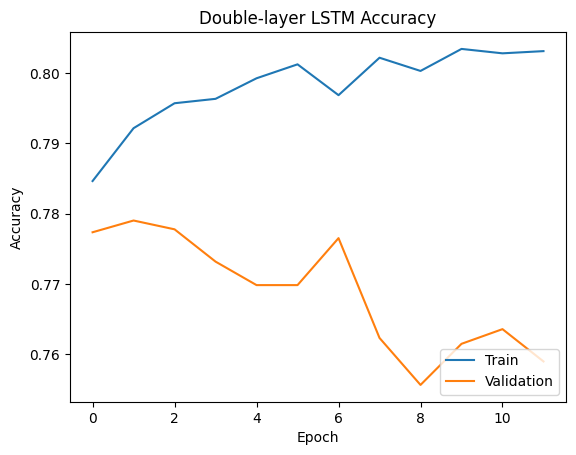

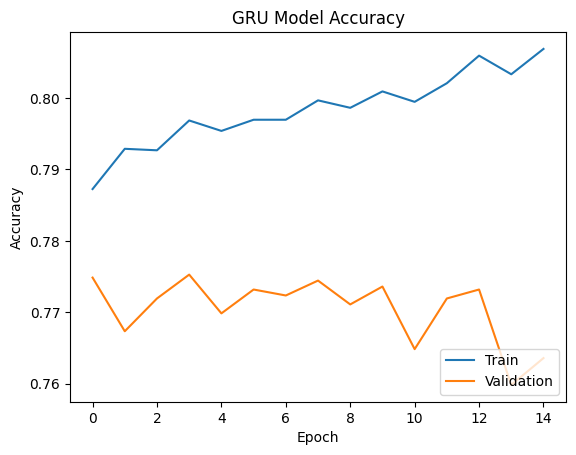

In [14]:
import matplotlib.pyplot as plt

def plot_history(history, title="Model Accuracy"):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='lower right')
    plt.show()

plot_history(history, "Double-layer LSTM Accuracy")
plot_history(history_gru, "GRU Model Accuracy")

# 資料強化流程建議

In [15]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# 讀取資料
#df = pd.read_csv("data/CA_Weather_Fire_Dataset_1984-2025.csv")


# 讀取資料，假設df已載入且有DATE欄位(datetime型態)
df = df.sort_values('DATE')

# 1. 缺失值補齊 (用中位數)
imputer = SimpleImputer(strategy='median')
num_cols = df.select_dtypes(include=np.number).columns
df[num_cols] = imputer.fit_transform(df[num_cols])

# 2. 異常值檢測 - 以Z-score法為例
from scipy import stats
z_scores = np.abs(stats.zscore(df[num_cols]))
df = df[(z_scores < 3).all(axis=1)]  # 去除Z-score超過3的異常列

# 3. 類別不平衡 (假設目標欄為'FIRE_START_DAY')
X = df.drop(columns=['FIRE_START_DAY', 'DATE'])
y = df['FIRE_START_DAY']

print('Before SMOTE:', y.value_counts())

smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

print('After SMOTE:', pd.Series(y_res).value_counts())

# 4. 特徵工程 - 滯後特徵 & 差分
for lag in [7, 14, 21]:
    df[f'FIRE_START_DAY_lag_{lag}'] = df['FIRE_START_DAY'].shift(lag)
    for col in ['TEMP_RANGE', 'AVG_WIND_SPEED', 'PRECIPITATION']:
        df[f'{col}_diff_{lag}'] = df[col].diff(lag)

# 5. 週期性時間特徵
df['day_of_year'] = df['DATE'].dt.dayofyear
df['sin_day'] = np.sin(2 * np.pi * df['day_of_year'] / 365)
df['cos_day'] = np.cos(2 * np.pi * df['day_of_year'] / 365)
df['month'] = df['DATE'].dt.month
df['sin_month'] = np.sin(2 * np.pi * df['month'] / 12)
df['cos_month'] = np.cos(2 * np.pi * df['month'] / 12)

# 6. 標準化 (先去除含NaN的滯後與差分列)
df = df.dropna()
features = df.drop(columns=['FIRE_START_DAY', 'DATE'])
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# 將處理後資料轉回 DataFrame
df_scaled = pd.DataFrame(features_scaled, columns=features.columns)
df_scaled['FIRE_START_DAY'] = df['FIRE_START_DAY'].values
df_scaled['DATE'] = df['DATE'].values

print(df_scaled.head())

Before SMOTE: FIRE_START_DAY
0.0    8622
1.0    4739
Name: count, dtype: int64
After SMOTE: FIRE_START_DAY
0.0    8622
1.0    8622
Name: count, dtype: int64
   PRECIPITATION  MAX_TEMP  MIN_TEMP  AVG_WIND_SPEED      YEAR  TEMP_RANGE  \
0      -0.175419 -1.362289 -1.821029       -0.309930 -1.701295    0.573966   
1      -0.175419 -0.747352 -1.821029       -0.962694 -1.701295    1.296399   
2      -0.175419 -0.132414 -1.367257       -1.743681 -1.701295    1.477008   
3      -0.175419  0.482523 -0.913485       -0.700423 -1.701295    1.657616   
4      -0.175419  1.251194 -0.005941        0.733328 -1.701295    1.477008   

   WIND_TEMP_RATIO     MONTH  LAGGED_PRECIPITATION  LAGGED_AVG_WIND_SPEED  \
0         0.191170 -1.706283              0.904297              -1.163044   
1        -0.686593 -1.706283             -0.364397              -1.285376   
2        -1.581287 -1.706283             -0.364397              -1.431738   
3        -0.801322 -1.706283             -0.364397              -1

# DNN

In [17]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split

# 假設 df_scaled 已完成前處理與標準化，並包含 'FIRE_START_DAY' 目標欄

X = df_scaled.drop(columns=['FIRE_START_DAY', 'DATE']).values
y = df_scaled['FIRE_START_DAY'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train,
                    validation_split=0.2,
                    epochs=100,
                    batch_size=64,
                    callbacks=[early_stop])

loss, DNN_accuracy = model.evaluate(X_test, y_test)
print(f'DNN Test Accuracy: {DNN_accuracy:.4f}')


Epoch 1/100


C:\Users\ygz08\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7225 - loss: 0.5432 - val_accuracy: 0.7813 - val_loss: 0.4562
Epoch 2/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7875 - loss: 0.4609 - val_accuracy: 0.7831 - val_loss: 0.4549
Epoch 3/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7948 - loss: 0.4493 - val_accuracy: 0.7794 - val_loss: 0.4544
Epoch 4/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7835 - loss: 0.4573 - val_accuracy: 0.7803 - val_loss: 0.4545
Epoch 5/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7913 - loss: 0.4479 - val_accuracy: 0.7813 - val_loss: 0.4526
Epoch 6/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7917 - loss: 0.4513 - val_accuracy: 0.7822 - val_loss: 0.4561
Epoch 7/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7950 - loss: 0.4461 - val_accuracy: 0.7803 - val_loss: 0.4539
Epoch 8/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8032 - loss: 0.4378 - val_accuracy: 0.7817

# DNN + 時間序列擴充：把時間窗拉長到30天以上

In [18]:
import numpy as np
import pandas as pd
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping

# 假設df_scaled是前面標準化後的DataFrame，包含日期與標的FIRE_START_DAY

# 只取特徵欄（不含日期與目標欄）
feature_cols = [c for c in df_scaled.columns if c not in ['DATE', 'FIRE_START_DAY']]
features = df_scaled[feature_cols].values
labels = df_scaled['FIRE_START_DAY'].values

window_size = 30

X = []
y = []

# 用前30天資料預測當天（第30天）目標
for i in range(window_size, len(features)):
    X.append(features[i-window_size:i])  # 30天的特徵矩陣 (30, feature_num)
    y.append(labels[i])

X = np.array(X)
y = np.array(y)

print('Input shape:', X.shape)  # (樣本數, 30, 特徵數)
print('Output shape:', y.shape)

# 分訓練/測試
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# 簡單DNN模型 (Flatten + Dense)
model = Sequential([
    Flatten(input_shape=(window_size, X.shape[2])),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

history = model.fit(X_train, y_train,
                    validation_split=0.2,
                    epochs=100,
                    batch_size=64,
                    callbacks=[early_stop])

loss, DNN30_accuracy = model.evaluate(X_test, y_test)
print(f'DNN (30-day window) Test Accuracy: {DNN30_accuracy:.4f}')


Input shape: (13310, 30, 50)
Output shape: (13310,)
Epoch 1/100


C:\Users\ygz08\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6983 - loss: 1.3208 - val_accuracy: 0.7803 - val_loss: 1.0269
Epoch 2/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7463 - loss: 1.0501 - val_accuracy: 0.7869 - val_loss: 0.9354
Epoch 3/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7721 - loss: 0.9426 - val_accuracy: 0.7887 - val_loss: 0.8753
Epoch 4/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7687 - loss: 0.8690 - val_accuracy: 0.7897 - val_loss: 0.7993
Epoch 5/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7831 - loss: 0.7804 - val_accuracy: 0.7840 - val_loss: 0.7433
Epoch 6/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7833 - loss: 0.7297 - val_accuracy: 0.7887 - val_loss: 0.6843
Epoch 7/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7865 - loss: 0.6746 - val_accuracy: 0.7897 - val_loss: 0.6529
Epoch 8/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7886 - loss: 0.6358 - val_accuracy: 0.7930

#  LSTM + Attention 模型架構

In [19]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Input, LSTM, Dense, Dropout
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K

# Attention Layer 自訂義
class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                                 initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1),
                                 initializer="zeros")
        super(Attention, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)  # (batch_size, time_steps, 1)
        e = K.squeeze(e, axis=-1)  # (batch_size, time_steps)
        alpha = K.softmax(e)  # 注意力權重
        alpha = K.expand_dims(alpha, axis=-1)  # (batch_size, time_steps, 1)
        context = x * alpha  # 權重乘以輸入序列
        context = K.sum(context, axis=1)  # 對時間軸加權求和 (batch_size, features)
        return context

# 建立模型
input_shape = (window_size, X.shape[2])
inputs = Input(shape=input_shape)
x = LSTM(64, return_sequences=True)(inputs)
x = Attention()(x)
x = Dropout(0.5)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs, outputs)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

# 訓練
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

history = model.fit(X_train, y_train,
                    validation_split=0.2,
                    epochs=100,
                    batch_size=64,
                    callbacks=[early_stop])

# 測試
loss, LSTM_Attention_accuracy = model.evaluate(X_test, y_test)
print(f'LSTM+Attention Test Accuracy: {LSTM_Attention_accuracy:.4f}')


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 30, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 30, 64)         │        29,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention (Attention)           │ (None, 64)             │            94 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,647 (123.62 KB)

 Trainable params: 31,647 (123.62 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7104 - loss: 0.5635 - val_accuracy: 0.7864 - val_loss: 0.4526
Epoch 2/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7740 - loss: 0.4932 - val_accuracy: 0.7887 - val_loss: 0.4508
Epoch 3/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7702 - loss: 0.4833 - val_accuracy: 0.7897 - val_loss: 0.4497
Epoch 4/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7793 - loss: 0.4735 - val_accuracy: 0.7925 - val_loss: 0.4474
Epoch 5/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7751 - loss: 0.4774 - val_accuracy: 0.7925 - val_loss: 0.4487
Epoch 6/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7858 - loss: 0.4677 - val_accuracy: 0.7906 - val_loss: 0.4469
Epoch 7/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7810 - loss: 0.4624 - val_accuracy: 0.7958 - val_loss: 0.4450
Epoch 8/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7900 - loss: 0.4570 - val_accu

# 視覺化

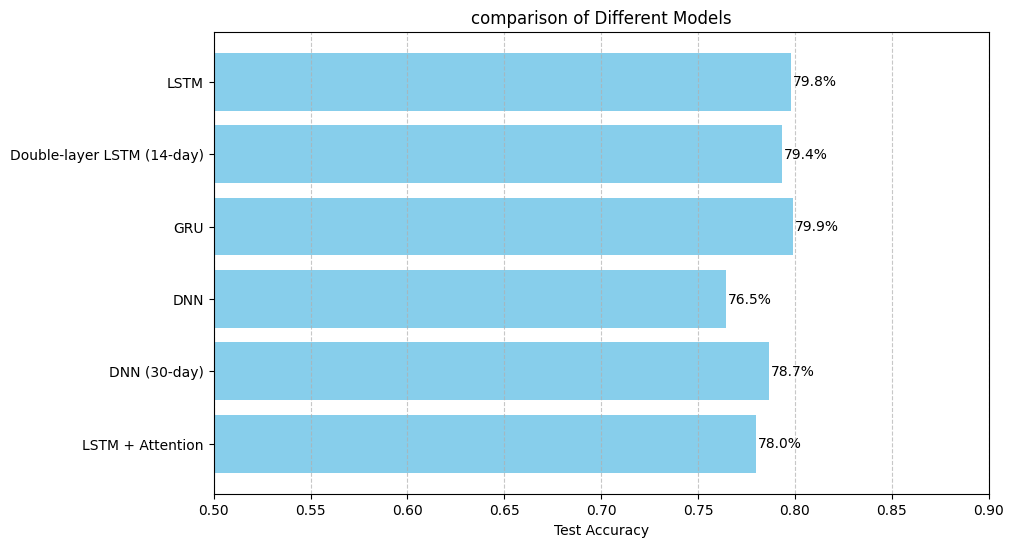

In [30]:
import matplotlib.pyplot as plt

# 模型名稱
models = [
    "LSTM",
    "Double-layer LSTM (14-day)",
    "GRU",
    "DNN",
    "DNN (30-day)",
    "LSTM + Attention"
]

# 對應準確率
accuracies = [
    LSTM_accuracy,
    DLLSTM_accuracy,
    acc_gru,
    DNN_accuracy,
    DNN30_accuracy,
    LSTM_Attention_accuracy
]
models = models[::-1]
accuracies = accuracies[::-1]

# 繪製橫向長條圖
plt.figure(figsize=(10, 6))
bars = plt.barh(models, accuracies, color='skyblue')
plt.xlabel('Test Accuracy')
plt.title('comparison of Different Models')
plt.xlim(0.5, 0.9)

# 在長條圖上標記數值
for bar, acc in zip(bars, accuracies):
    plt.text(acc + 0.001, bar.get_y() + bar.get_height()/2, f"{acc*100:.1f}%", va='center')

plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()
